# Economic Model - Part 1: Unemployment rate

## 1- Introduction

In this model, the main goal will be to determine the GDP variables that affect the most to the unemployment rate in Spain by:

**1. GDP variable:** internal consumption, gross fixed capital formation, exportation and importation.

**2. By sector:** which are the sectors that have a strongest impact on Spain's unemployment rate.

In order to do so, the following steps will be completed:
1. Data wrangling.
2. Determination of each variable's correlation with the unemployment rate depending on the time shift.
3. Building of the above-mentioned regression models (by GDP variable and by sector).

## 2- Data wrangling

In this section, we will prepare all the data for our analysis.

In [23]:
#We first import the necessary libraries
import requests
from datetime import datetime
import pandas as pd
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
#We then extract the tables from the INE API:
"""
df.drop(['Secreto'],axis=1, inplace = True)
df.drop(['FK_TipoDato'],axis=1, inplace = True)
df
"""
def INE_extractor(code,num_data):
    url_template = 'http://servicios.ine.es/wstempus/js/EN/DATOS_TABLA/{codigo}?nult={num_datos}'
    url = url_template.format(codigo=code, num_datos=num_data)
    response = requests.get(url)
    data = response.json()
    df = pd.json_normalize(data)
    df = df[df['Nombre'].str.contains('National Total')]
    df.drop(['FK_Unidad','FK_Escala'],axis = 1, inplace = True)
    return df

In [3]:
#We first extract the unemployment rate data (our dependent variable):
unemployment = INE_extractor('4247',4*20)
unemployment = unemployment[unemployment['Nombre'].str.contains('Both sexes')]
unemployment = unemployment[unemployment['Nombre'].str.contains('All ages')]
unemployment['Nombre'] = 'Unemployment rate'
unemployment = pd.concat([pd.DataFrame(x) for x in unemployment['Data']],
                         keys=unemployment['Nombre']).reset_index(level=1, drop=True).reset_index()
unemployment['Fecha'] = [datetime.fromtimestamp(x/1000)for x in unemployment['Fecha']]
unemployment.drop(['Secreto','FK_TipoDato','FK_Periodo'],axis=1,inplace=True)
unemployment

,Nombre,Fecha,Anyo,Valor
0,Unemployment rate,2020-04-01,2020,15.33
1,Unemployment rate,2020-01-01,2020,14.41
2,Unemployment rate,2019-10-01,2019,13.78
3,Unemployment rate,2019-07-01,2019,13.92
4,Unemployment rate,2019-04-01,2019,14.02
...,...,...,...,...
69,Unemployment rate,2003-01-01,2003,11.99
70,Unemployment rate,2002-10-01,2002,11.61
71,Unemployment rate,2002-07-01,2002,11.49
72,Unemployment rate,2002-04-01,2002,11.15


In [4]:
#We then extract the main GDP by demand variables (our independent variables for the first regression model):
GDP_demand = INE_extractor('28604',4*20)
GDP_demand = GDP_demand[GDP_demand['Nombre'].str.contains(' adjusted')]
GDP_demand = GDP_demand[GDP_demand['Nombre'].str.contains('Base data')]
GDP_demand['Nombre'] = GDP_demand['Nombre'].str.replace('National Total. Base 2010. Seasonally and calendar adjusted data. ','')
GDP_demand['Nombre'] = GDP_demand['Nombre'].str.replace('. Base data. Current prices. ','')
values = ['Final consumption expenditure','Gross capital formation',
          'Exports of goods','Exports of services','Imports of goods','Imports of services']
GDP_demand = GDP_demand[GDP_demand['Nombre'].isin(values)]
GDP_demand = pd.concat([pd.DataFrame(x) for x in GDP_demand['Data']],
                         keys=GDP_demand['Nombre']).reset_index(level=1, drop=True).sort_values('Fecha',ascending = False).reset_index()
GDP_demand.drop(['Secreto','FK_TipoDato','FK_Periodo'],axis=1,inplace=True)
GDP_demand['Fecha'] = [datetime.fromtimestamp(x/1000)for x in GDP_demand['Fecha']]
GDP_demand.head(10)

,Nombre,Fecha,Anyo,Valor
0,Final consumption expenditure,2019-04-01,2019,235998.0
1,Gross capital formation,2019-04-01,2019,68637.0
2,Imports of services,2019-04-01,2019,19233.0
3,Imports of goods,2019-04-01,2019,80655.0
4,Exports of goods,2019-04-01,2019,73728.0
5,Exports of services,2019-04-01,2019,32664.0
6,Gross capital formation,2019-01-01,2019,68306.0
7,Exports of goods,2019-01-01,2019,70694.0
8,Imports of services,2019-01-01,2019,19739.0
9,Final consumption expenditure,2019-01-01,2019,233776.0


In [5]:
#And we finally extract the GDP by sector (our independent variables for the second regression model):
GDP_offer = INE_extractor('28602',4*20)
GDP_offer = GDP_offer[GDP_offer['Nombre'].str.contains(' adjusted')]
GDP_offer = GDP_offer[GDP_offer['Nombre'].str.contains('Base data')]
GDP_offer['Nombre'] = GDP_offer['Nombre'].str.replace('National Total. Base 2010. Seasonally and calendar adjusted data. ','')
GDP_offer['Nombre'] = GDP_offer['Nombre'].str.replace('. Base data. Current prices. ','')
values = list(GDP_offer['Nombre'].unique())
values_refined = [values[1]] + values[3:5] + values [6:13]
GDP_offer = GDP_offer[GDP_offer['Nombre'].isin(values_refined)]
GDP_offer = pd.concat([pd.DataFrame(x) for x in GDP_offer['Data']],
                         keys=GDP_offer['Nombre']).reset_index(level=1, drop=True).sort_values(['Fecha','Nombre'],ascending = False).reset_index()
GDP_offer.drop(['Secreto','FK_TipoDato','FK_Periodo'],axis=1,inplace=True)
GDP_offer['Fecha'] = [datetime.fromtimestamp(x/1000)for x in GDP_offer['Fecha']]
GDP_offer['Nombre'] = GDP_offer['Nombre'].apply(lambda x: re.sub(r'\(.+\)','',x))
GDP_offer['Nombre'] = GDP_offer['Nombre'].str.replace('GVApb ','')
GDP_offer['Nombre'] = GDP_offer['Nombre'].str.replace('GVAbp ','')
GDP_offer['Type'] = ['Construction' if 'Construction' in x 
                     else 'Services' if 'Services activities. ' in x 
                     else 'Industry' if 'Industry' in x
                    else 'Others' for x in GDP_offer['Nombre']]
GDP_offer['Nombre'] = GDP_offer['Nombre'].apply(lambda x: re.sub(r'.+\. ','',x))
GDP_offer.head(10)

,Nombre,Fecha,Anyo,Valor,Type
0,Construction,2019-04-01,2019,19230.0,Construction
1,Real estate activities,2019-04-01,2019,29825.0,Services
2,"Public administration, education and health ac...",2019-04-01,2019,51433.0,Services
3,Professiona scientific and technical activitie...,2019-04-01,2019,23985.0,Services
4,Information and communications,2019-04-01,2019,11455.0,Services
5,Financial and insurance activities,2019-04-01,2019,11345.0,Services
6,Arts entertainment and other services,2019-04-01,2019,10507.0,Services
7,"Service activities.Trade, transport and accomm...",2019-04-01,2019,67090.0,Others
8,Manufacturing industry,2019-04-01,2019,38392.0,Industry
9,"Agriculture, forestry, livestock and fishing",2019-04-01,2019,7747.0,Others


## 3- Unemployment rate vs. GDP variables

In this section, we will try to estimate the uneomployment rate based on final consumption, gross capital formation, imports and exports.

### 3.1 - Time shift determination

In this sub-section, we will try to find, for each variable, the time shift with which it has the highest correlation with the current unemployment rate.

In [6]:
#We first join the unemployment rate (dependent variable) to the independent variables:
data_1 = GDP_demand.merge(unemployment,on = 'Fecha',how = 'inner')
data_1.rename(columns = {'Nombre_x':'Variable','Fecha':'Date','Valor_x':'X','Valor_y':'Unemployment rate'},inplace = True)
data_1.drop(['Nombre_y','Anyo_y','Anyo_x'],axis = 1, inplace=True)
data_1 = data_1.sort_values(['Date','Variable'],ascending = False).reset_index(drop=True)
#I will now create a column for eah independent variable, in order to then calculate the variations and correlations:
values_demand = ['Final consumption expenditure','Gross capital formation',
          'Exports of goods','Exports of services','Imports of goods','Imports of services']
for var in values_demand:
    data_1[var] = [data_1['X'][i] if data_1['Variable'][i] == var else 0 for i in range(len(data_1['Variable']))]
data_1.drop(columns = 'X',inplace = True)
#I now group the independent and dependent variables by date:
data_grouped = data_1.groupby('Date').sum()
data_grouped['Unemployment rate'] = data_grouped['Unemployment rate'] / len(values_demand)
#And I finally obtain the variations:
data_grouped_variations = data_grouped.iloc[1:].copy()
data_grouped_variations['Unemployment rate'] = [data_grouped['Unemployment rate'][i] - data_grouped['Unemployment rate'][i-1] for i in range(1,len(data_grouped))]
for var in values_demand:
    data_grouped_variations[var] = [100*(data_grouped[var][i] / data_grouped[var][i-1] - 1) for i in range(1,len(data_grouped))]
data_grouped_variations

,Unemployment rate,Final consumption expenditure,Gross capital formation,Exports of goods,Exports of services,Imports of goods,Imports of services
Date,,,,,,,
2002-04-01,-0.40,1.586874,3.129190,0.884612,0.992572,1.324862,1.247338
2002-07-01,0.34,1.971613,1.126090,-1.795183,1.337899,-0.204375,0.821314
2002-10-01,0.12,1.328616,3.896438,3.849054,1.520461,4.484524,1.917346
2003-01-01,0.38,0.914852,3.101144,1.777674,-0.449923,-0.516738,-1.111219
2003-04-01,-0.71,1.771159,1.408841,-1.087360,1.405399,0.394045,-0.502711
...,...,...,...,...,...,...,...
2018-04-01,-1.46,0.697483,3.744211,0.360131,1.634425,1.813943,-0.779323
2018-07-01,-0.73,1.124082,1.259332,0.199665,-0.527671,0.503284,5.023450
2018-10-01,-0.10,0.861058,0.650879,-0.048772,3.738554,0.671023,0.129129


In [7]:
#Once we have the quarterly variations, we apply the time shifts between the independent variables and the unemployment rate:
data_quarterly = data_grouped_variations.iloc[1:].copy()
data_biannual = data_grouped_variations.iloc[2:].copy()
data_three_quarters = data_grouped_variations.iloc[3:].copy()
data_yearly = data_grouped_variations.iloc[4:].copy()
for var in values_demand:
    data_quarterly[var] = [data_grouped_variations[var][i-1] for i in range(1,len(data_grouped_variations))]
    data_biannual[var] = [data_grouped_variations[var][i-2] for i in range(2,len(data_grouped_variations))]
    data_three_quarters[var] = [data_grouped_variations[var][i-3] for i in range(3,len(data_grouped_variations))]
    data_yearly[var] = [data_grouped_variations[var][i-4] for i in range(4,len(data_grouped_variations))]
#We finally obtain the correlations and find the best one for each variable:
correlations = {}
for var in values_demand:
    q = data_quarterly.corr()['Unemployment rate'][var]
    b = data_biannual.corr()['Unemployment rate'][var]
    t = data_three_quarters.corr()['Unemployment rate'][var]
    y = data_yearly.corr()['Unemployment rate'][var]
    m = max(q**2,b**2,t**2,y**2)
    if m == q**2:
        correlations[var] = ('Quarterly',q)
    elif m == b**2:
        correlations[var] = ('Biannual',b)
    elif m == t**2:
        correlations[var] = ('Three quarters',t)
    else:
        correlations[var] = ('Annual',t)
print(*correlations.items(),sep='\n')
#We cross-check the results with the Spearman correlations:
correlations_spearman = {}
for var in values_demand:
    q = data_quarterly.corr(method='spearman')['Unemployment rate'][var]
    b = data_biannual.corr(method='spearman')['Unemployment rate'][var]
    t = data_three_quarters.corr(method='spearman')['Unemployment rate'][var]
    y = data_yearly.corr(method='spearman')['Unemployment rate'][var]
    m = max(q**2,b**2,t**2,y**2)
    if m == q**2:
        correlations_spearman[var] = ('Quarterly',q)
    elif m == b**2:
        correlations_spearman[var] = ('Biannual',b)
    elif m == t**2:
        correlations_spearman[var] = ('Three quarters',t)
    else:
        correlations_spearman[var] = ('Annual',y)
correlations_spearman

('Final consumption expenditure', ('Quarterly', -0.3934028692903969))
('Gross capital formation', ('Quarterly', -0.5195235991143426))
('Exports of goods', ('Quarterly', -0.2496757982870256))
('Exports of services', ('Biannual', -0.18567348606719628))
('Imports of goods', ('Quarterly', -0.40020771570891256))
('Imports of services', ('Three quarters', -0.29289404368817995))


{'Final consumption expenditure': ('Quarterly', -0.30399099121831286),
 'Gross capital formation': ('Quarterly', -0.4872406620092353),
 'Exports of goods': ('Annual', 0.1620227715153389),
 'Exports of services': ('Biannual', -0.2326050085268026),
 'Imports of goods': ('Quarterly', -0.2908594660121724),
 'Imports of services': ('Three quarters', -0.2525258851585619)}

### 3.2 - Linear Regression Model

Now that we have determined for each independent variable, based on its correlation with the unemployment, the time shift that shall be taken into account, it's time to build the linear regression model based on these time shifts:

In [8]:
#We first create a dataframe based on each variable's time shift:
data_regression = data_yearly.copy()
for key in correlations.keys():
    if correlations[key][0] == 'Quarterly':
        data_regression[key] = data_quarterly[key][3:]
        data_regression.rename(columns = {key: key + ' Quarterly'},inplace = True)
    elif correlations[key][0] == 'Biannual':
        data_regression[key] = data_biannual[key][2:]
        data_regression.rename(columns = {key: key + ' Biannual'},inplace = True)
    elif correlations[key][0] == 'Three quarters':
        data_regression[key] = data_three_quarters[key][1:]
        data_regression.rename(columns = {key: key + ' 3Q'},inplace = True)
    else:
        data_regression.rename(columns = {key: key + ' Yearly'}, inplace = True)
data_regression.head(10)

,Unemployment rate,Final consumption expenditure Quarterly,Gross capital formation Quarterly,Exports of goods Quarterly,Exports of services Biannual,Imports of goods Quarterly,Imports of services 3Q
Date,,,,,,,
2003-04-01,-0.71,0.914852,3.101144,1.777674,1.520461,-0.516738,0.821314
2003-07-01,0.02,1.771159,1.408841,-1.087360,-0.449923,0.394045,1.917346
2003-10-01,0.07,1.970803,2.736658,-1.679266,1.405399,0.452711,-1.111219
2004-01-01,0.13,1.745142,2.881752,4.225848,-0.207583,4.320220,-0.502711
2004-04-01,-0.41,2.164042,1.874246,3.271765,-0.293668,4.168972,0.594413
2004-07-01,-0.35,2.210660,3.285536,2.069360,2.147635,4.290180,1.831790
2004-10-01,-0.21,2.262661,2.372260,-1.760291,-0.750886,1.065643,5.705996
2005-01-01,-0.36,1.197499,3.844555,4.170972,3.468103,3.981160,1.354071
2005-04-01,-0.85,1.934438,2.673484,-1.889747,1.942088,-0.227413,1.823434


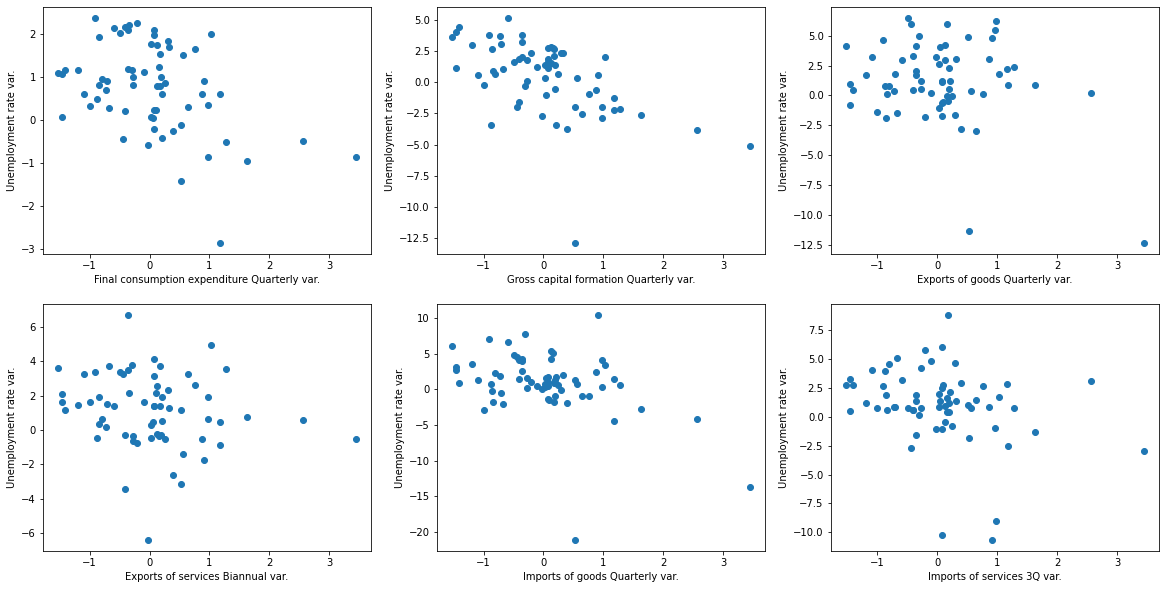

In [19]:
"""
Once we have the data with each variable's time shift, we look at the scatter plots to see if there is any linear
relationship at all:
"""
f, ax = plt.subplots(2,3,figsize = (20,10))
for i in range(2):
    for j in range(3):
        if i == 0:
            col_index = 1 + j
        else:
            col_index = 4 + j
        plt.sca(ax[i,j])
        plt.ylabel('Unemployment rate var.')
        plt.scatter(data_regression['Unemployment rate'],data_regression.iloc[:,col_index])
        plt.xlabel(data_regression.columns[col_index] + ' var.')

In [24]:
#We finally compute the multiple regression model to determine which variables should be included:
X = data_regression.iloc[:,1:]
y = data_regression['Unemployment rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      Unemployment rate   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     4.920
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           0.000396
Time:                        14:47:35   Log-Likelihood:                -71.418
No. Observations:                  65   AIC:                             156.8
Df Residuals:                      58   BIC:                             172.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [27]:
#As we can see, the independent variables with the highest p-values are consumption and exports, so we will remove them from our analysis:
data_regression_2 = data_regression.drop(columns = ['Final consumption expenditure Quarterly','Exports of goods Quarterly','Exports of services Biannual'])
X = data_regression_2.iloc[:,1:]
y = data_regression_2['Unemployment rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      Unemployment rate   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     10.27
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           1.45e-05
Time:                        14:53:04   Log-Likelihood:                -71.506
No. Observations:                  65   AIC:                             151.0
Df Residuals:                      61   BIC:                             159.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [29]:
#We now eliminate imports of goods:
data_regression_3 = data_regression_2.drop(columns = ['Imports of goods Quarterly'])
X = data_regression_3.iloc[:,1:]
y = data_regression_3['Unemployment rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      Unemployment rate   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     14.81
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           5.51e-06
Time:                        14:58:39   Log-Likelihood:                -72.095
No. Observations:                  65   AIC:                             150.2
Df Residuals:                      62   BIC:                             156.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [40]:
#We end up with a simple linear regression model as follows:
y = data_regression_3['Unemployment rate'].values
x = data_regression_3['Gross capital formation Quarterly'].values.reshape(-1,1)
model = LinearRegression().fit(x, y)
intercept = model.intercept_
slope = model.coef_[0]
r_sq = model.score(x,y)
print(slope,intercept,r_sq)

-0.16784545782315313 0.10634799990300806 0.2934763696013545


Text(0, 0.5, 'Unemployment rate var. (%)')

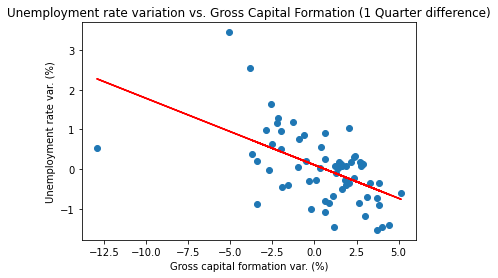

In [57]:
unempl = data_regression_3['Unemployment rate']
unempl_predicted = [slope*e + intercept for e in data_regression_3['Gross capital formation Quarterly']]
gcf = data_regression_3['Gross capital formation Quarterly']
plt.scatter(gcf,unempl)
plt.plot(gcf,unempl_predicted, color = 'red')
plt.title ('Unemployment rate variation vs. Gross Capital Formation (1 Quarter difference)')
plt.xlabel('Gross capital formation var. (%)')
plt.ylabel('Unemployment rate var. (%)')

## 4- Unemployment rate vs. GDP by sector

In this section, we will try to estimate the uneomployment rate based on the GDP by sector.

### 4.1 - Time shift determination

In this sub-section, we will try to find, for each variable, the time shift with which it has the highest correlation with the current unemployment rate.

In [59]:
#We first join the unemployment rate (dependent variable) to the independent variables:
data_2 = GDP_offer.merge(unemployment,on = 'Fecha',how = 'inner')
data_2.rename(columns = {'Nombre_x':'Variable','Fecha':'Date','Valor_x':'X','Valor_y':'Unemployment rate'},inplace = True)
data_2.drop(['Nombre_y','Anyo_y','Anyo_x'],axis = 1, inplace=True)
data_2 = data_2.sort_values(['Date','Variable'],ascending = False).reset_index(drop=True)
#I will now create a column for eah independent variable, in order to then calculate the variations and correlations:
values_offer = list(GDP_offer['Nombre'].unique())
for var in values_offer:
    data_2[var] = [data_2['X'][i] if data_2['Variable'][i] == var else 0 for i in range(len(data_2))]
data_2.drop(columns = 'X',inplace = True)
#I now group the independent and dependent variables by date:
data_2_grouped = data_2.groupby('Date').sum()
data_2_grouped['Unemployment rate'] = data_2_grouped['Unemployment rate'] / len(values_offer)
#And I finally obtain the variations:
data_2_grouped_variations = data_2_grouped.iloc[1:].copy()
data_2_grouped_variations['Unemployment rate'] = [data_2_grouped['Unemployment rate'][i] - data_2_grouped['Unemployment rate'][i-1] for i in range(1,len(data_2_grouped))]
for var in values_offer:
    data_2_grouped_variations[var] = [100*(data_2_grouped[var][i] / data_2_grouped[var][i-1] - 1) for i in range(1,len(data_2_grouped))]
data_2_grouped_variations

,Unemployment rate,Construction,Real estate activities,"Public administration, education and health activities",Professiona scientific and technical activities and others,Information and communications,Financial and insurance activities,Arts entertainment and other services,"Service activities.Trade, transport and accommodation and restaurants",Manufacturing industry,"Agriculture, forestry, livestock and fishing"
Date,,,,,,,,,,,
2002-04-01,-0.40,0.958308,3.988363,-0.632864,2.927992,2.105263,7.378296,8.460154,0.468456,3.080199,-9.956332
2002-07-01,0.34,-1.336534,1.290497,3.639396,1.278725,2.392771,-1.523022,2.097164,3.286706,-1.552603,5.383123
2002-10-01,0.12,5.368794,5.639701,-0.599898,5.425435,1.479180,0.035967,0.886656,2.500061,2.587684,-3.113975
2003-01-01,0.38,3.704675,0.978325,6.848458,-0.971969,0.722685,2.828380,-4.892339,-1.192015,1.629342,1.155795
2003-04-01,-0.71,0.586955,3.908795,-1.319098,3.189904,2.760550,-2.179487,8.378254,1.087694,0.409190,4.664267
...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,-1.46,2.689144,0.536052,1.386707,2.108609,1.424552,-0.894454,-1.320257,1.321819,1.223588,0.588972
2018-07-01,-0.73,1.942740,0.561073,0.911148,1.574009,-0.312121,4.892647,0.898318,0.062853,-0.595300,-4.871060
2018-10-01,-0.10,2.474089,1.098558,0.923120,1.407174,0.495738,3.242460,-0.369388,1.196513,-0.604095,4.531168


In [60]:
#Once we have the quarterly variations, we apply the time shifts between the independent variables and the unemployment rate:
data_2_quarterly = data_2_grouped_variations.iloc[1:].copy()
data_2_biannual = data_2_grouped_variations.iloc[2:].copy()
data_2_three_quarters = data_2_grouped_variations.iloc[3:].copy()
data_2_yearly = data_2_grouped_variations.iloc[4:].copy()
for var in values_offer:
    data_2_quarterly[var] = [data_2_grouped_variations[var][i-1] for i in range(1,len(data_2_grouped_variations))]
    data_2_biannual[var] = [data_2_grouped_variations[var][i-2] for i in range(2,len(data_2_grouped_variations))]
    data_2_three_quarters[var] = [data_2_grouped_variations[var][i-3] for i in range(3,len(data_2_grouped_variations))]
    data_2_yearly[var] = [data_2_grouped_variations[var][i-4] for i in range(4,len(data_2_grouped_variations))]
#We finally obtain the correlations and find the best one for each variable:
correlations_2 = {}
for var in values_offer:
    q = data_2_quarterly.corr()['Unemployment rate'][var]
    b = data_2_biannual.corr()['Unemployment rate'][var]
    t = data_2_three_quarters.corr()['Unemployment rate'][var]
    y = data_2_yearly.corr()['Unemployment rate'][var]
    m = max(q**2,b**2,t**2,y**2)
    if m == q**2:
        correlations_2[var] = ('Quarterly',q)
    elif m == b**2:
        correlations_2[var] = ('Biannual',b)
    elif m == t**2:
        correlations_2[var] = ('Three quarters',t)
    else:
        correlations_2[var] = ('Annual',t)
print(*correlations_2.items(),sep='\n')
#We cross-check the results with the Spearman correlations:
correlations_spearman_2 = {}
for var in values_offer:
    q = data_2_quarterly.corr(method='spearman')['Unemployment rate'][var]
    b = data_2_biannual.corr(method='spearman')['Unemployment rate'][var]
    t = data_2_three_quarters.corr(method='spearman')['Unemployment rate'][var]
    y = data_2_yearly.corr(method='spearman')['Unemployment rate'][var]
    m = max(q**2,b**2,t**2,y**2)
    if m == q**2:
        correlations_spearman_2[var] = ('Quarterly',q)
    elif m == b**2:
        correlations_spearman_2[var] = ('Biannual',b)
    elif m == t**2:
        correlations_spearman_2[var] = ('Three quarters',t)
    else:
        correlations_spearman_2[var] = ('Annual',y)
correlations_spearman_2

('Construction ', ('Quarterly', -0.36152824983736576))
('Real estate activities ', ('Annual', 0.11933478283996081))
('Public administration, education and health activities ', ('Annual', 0.08612030597798437))
('Professiona scientific and technical activities and others ', ('Quarterly', -0.2788430394732702))
('Information and communications ', ('Quarterly', -0.23142954689769668))
('Financial and insurance activities ', ('Biannual', -0.11936624924718274))
('Arts entertainment and other services ', ('Biannual', 0.17158954470395504))
('Service activities.Trade, transport and accommodation and restaurants ', ('Quarterly', -0.3715936598767016))
('Manufacturing industry ', ('Quarterly', -0.35679978468324913))
('Agriculture, forestry, livestock and fishing  ', ('Biannual', -0.14192866383927008))


{'Construction ': ('Biannual', -0.3868141956655945),
 'Real estate activities ': ('Three quarters', 0.19720691387062367),
 'Public administration, education and health activities ': ('Quarterly',
  -0.13448489770268135),
 'Professiona scientific and technical activities and others ': ('Quarterly',
  -0.17118862439616078),
 'Information and communications ': ('Annual', -0.15835136261129562),
 'Financial and insurance activities ': ('Biannual', -0.10284448617283848),
 'Arts entertainment and other services ': ('Biannual', 0.29939438698821663),
 'Service activities.Trade, transport and accommodation and restaurants ': ('Quarterly',
  -0.2140382689239098),
 'Manufacturing industry ': ('Biannual', -0.2969799161254084),
 'Agriculture, forestry, livestock and fishing  ': ('Biannual',
  -0.1544862266104221)}

In [61]:
#We first create a dataframe based on each variable's time shift:
data_regression_offer = data_2_yearly.copy()
for key in correlations_2.keys():
    if correlations_2[key][0] == 'Quarterly':
        data_regression_offer[key] = data_2_quarterly[key][3:]
        data_regression_offer.rename(columns = {key: key + ' Quarterly'},inplace = True)
    elif correlations_2[key][0] == 'Biannual':
        data_regression_offer[key] = data_2_biannual[key][2:]
        data_regression_offer.rename(columns = {key: key + ' Biannual'},inplace = True)
    elif correlations_2[key][0] == 'Three quarters':
        data_regression_offer[key] = data_2_three_quarters[key][1:]
        data_regression_offer.rename(columns = {key: key + ' 3Q'},inplace = True)
    else:
        data_regression_offer.rename(columns = {key: key + ' Yearly'}, inplace = True)
data_regression_offer.head(10)

,Unemployment rate,Construction Quarterly,Real estate activities Yearly,"Public administration, education and health activities Yearly",Professiona scientific and technical activities and others Quarterly,Information and communications Quarterly,Financial and insurance activities Biannual,Arts entertainment and other services Biannual,"Service activities.Trade, transport and accommodation and restaurants Quarterly",Manufacturing industry Quarterly,"Agriculture, forestry, livestock and fishing Biannual"
Date,,,,,,,,,,,
2003-04-01,-0.71,3.704675,3.988363,-0.632864,-0.971969,0.722685,0.035967,0.886656,-1.192015,1.629342,-3.113975
2003-07-01,0.02,0.586955,1.290497,3.639396,3.189904,2.760550,2.828380,-4.892339,1.087694,0.409190,1.155795
2003-10-01,0.07,-0.487952,5.639701,-0.599898,0.501062,1.136095,-2.179487,8.378254,3.079393,-0.350737,4.664267
2004-01-01,0.13,2.456779,0.978325,6.848458,5.239141,0.725486,1.679971,1.577377,0.841586,1.173237,1.525348
2004-04-01,-0.41,3.429051,3.908795,-1.319098,-3.902361,-0.511152,3.011483,2.993844,2.005717,2.368962,7.615260
2004-07-01,-0.35,1.044698,4.010932,2.914282,2.682152,2.860813,0.989649,-3.966314,0.718709,0.621420,-9.211607
2004-10-01,-0.21,0.575961,1.877898,-1.326008,2.742290,2.872063,2.432980,6.647808,2.533435,0.598282,6.512890
2005-01-01,-0.36,5.787646,5.105060,6.660709,4.110565,1.059369,-0.505828,1.671088,1.888692,0.284572,-7.940552
2005-04-01,-0.85,5.178151,2.684758,-1.488690,-0.190186,0.196549,5.028736,1.708844,-0.148209,2.649534,-3.505535


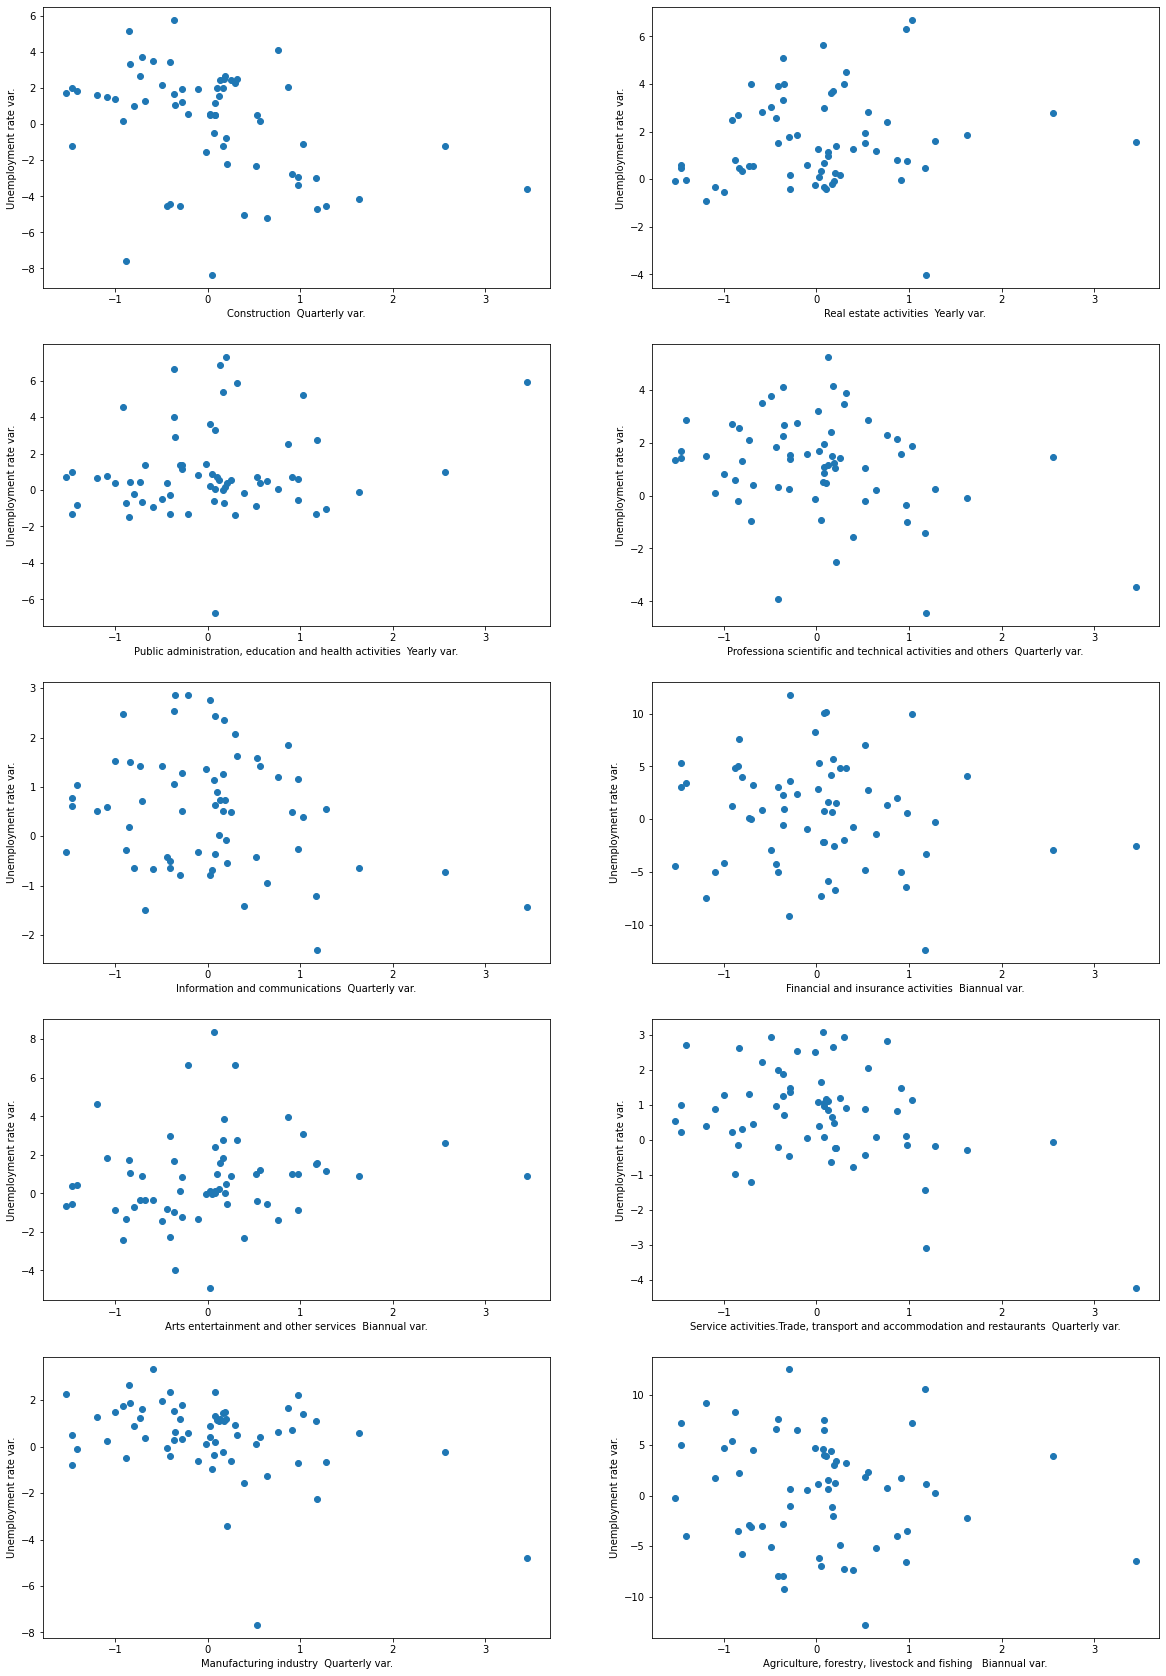

In [68]:
f, ax = plt.subplots(5,2,figsize = (20,30))
col_index = 1
for i in range(5):
    for j in range(2):
        plt.sca(ax[i,j])
        plt.ylabel('Unemployment rate var.')
        plt.scatter(data_regression['Unemployment rate'],data_regression_offer.iloc[:,col_index])
        plt.xlabel(data_regression_offer.columns[col_index] + ' var.')
        col_index += 1

In [69]:
#We finally compute the multiple regression model to determine which variables should be included:
X = data_regression_offer.iloc[:,1:]
y = data_regression_offer['Unemployment rate']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      Unemployment rate   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     3.602
Date:                Thu, 30 Jul 2020   Prob (F-statistic):            0.00103
Time:                        15:36:02   Log-Likelihood:                -68.180
No. Observations:                  65   AIC:                             158.4
Df Residuals:                      54   BIC:                             182.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------